# Inference

Load experimental images - both regular and enhanced and make predictions

#### Libraries 📚🔽

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from tqdm.notebook import tqdm
from scipy.constants import h, hbar, pi, k
from scipy.optimize import curve_fit

from tensorflow.keras.models import load_model

#### Constants

In [2]:
N = 70 
DX = 1.0e-6
f = 3 # filter size for NMS
mass = 87 * 1.6e-27
T = 50 * 1e-9
lambda_squared = h**2/(2 * pi * mass * k * T) # thermal de Broglie wavelength squared

## 1. Load Experimental Data and Trained Model

In [3]:
data_path = "../qvortex-detection/single_layer/essential/data"

In [4]:
images_curated = np.load(f"{data_path}/numpy_files/images_curated.npy")
images_enhanced = np.load(f"{data_path}/numpy_files/images_enhanced.npy")
masks_exp_curated = np.load(f"{data_path}/numpy_files/masks_exp_curated.npy")
psds_exp_curated = np.load(f"{data_path}/numpy_files/psds_exp_curated.npy")

In [5]:
model_name = "70_noise_v81"
model_path = f"../qvortex-detection/single_layer/essential/models/{model_name}.keras"
model = load_model(model_path, compile=False)

## 2. Helper Functions

In [6]:
def predict(model, images):
    preds = model.predict(images)[:, :, :, 0]
    preds_rounded = np.where(preds >= 0.5, 1, 0)
    preds_masked = np.multiply(preds_rounded, masks_exp_curated)
    
    return preds_masked

In [7]:
def nms(pred):
    pred_nms = pred.copy()
    for j in range(N - f):
        for i in range(N - f):
            filter = pred_nms[j:j+f, i:i+f]
            if (filter >= 0.5).sum() > 1:
                replacement = np.zeros((f, f))
                max_idx = np.unravel_index(np.argmax(filter), shape=filter.shape)
                if max_idx == (1, 1):
                    replacement[max_idx] = filter[max_idx]
                    pred_nms[j:j+f, i:i+f] = replacement

    return pred_nms

In [8]:
plt.hist(filters.flatten())

NameError: name 'filters' is not defined

##### first channel of every filter in first 3 layers

In [ ]:
for idx in range(len(layers) - 1):

    filters, biases = layers[idx].get_weights()
     
    # normalize filter values to 0-1 so we can visualize them
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    
    n_filters = layers[idx].filters
    fig, axes = plt.subplots(1, n_filters, figsize=(20, 4))
    for i, ax in enumerate(axes.flat):
        f = filters[:, :, 0, i]
        ax.set_axis_off()
        ax.imshow(f)
    plt.show()

##### all channels of only filter in final layer

In [ ]:
filters, biases = layers[-1].get_weights()
 
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_channels = filters.shape[2]
fig, axes = plt.subplots(1, n_channels, figsize=(20, 4))
for i, ax in enumerate(axes.flat):
    f = filters[:, :, i, 0]
    ax.set_axis_off()
    ax.imshow(f)
plt.show()

In [ ]:
ind = 0
plt.imshow(images_enhanced[ind])

In [ ]:
for j in range(len(layers)):
    vis_model = Model(inputs=model.inputs, outputs=layers[j].output)
    img = np.expand_dims(images_enhanced[ind], axis=0)
    feature_maps = vis_model.predict(img)
    
    n_maps = feature_maps.shape[3]
    fig, axes = plt.subplots(a:=math.ceil(n_maps / 10), 10, figsize=(20, 2*a))
    for i, ax in enumerate(axes.flat):
        if i < n_maps:
            fmap = feature_maps[0, :, :, i]
            ax.set_axis_off()
            ax.imshow(fmap)
        else:
            continue


## 3. Predict

In [9]:
preds = predict(model, images_enhanced)

28/28 [==============================] - 1s 3ms/step


In [10]:
preds_nms = np.zeros_like(preds)
for i in tqdm(range(preds.shape[0])):
    preds_nms[i] = nms(preds[i])

preds_nms_rounded = np.where(preds_nms >= 0.5, 1, 0)

  0%|          | 0/876 [00:00<?, ?it/s]

## 4. Visualise Predictions

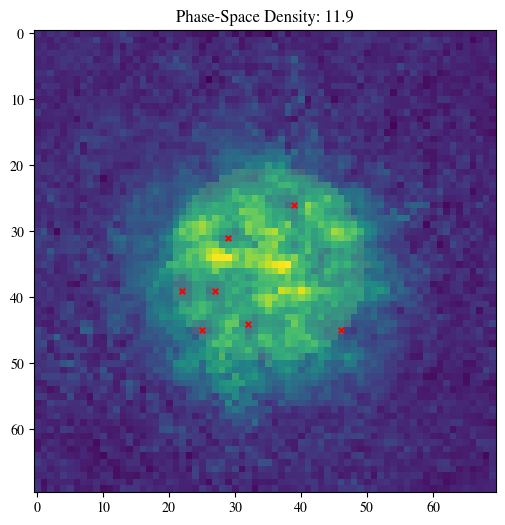

In [11]:
ind = 1

plt.figure(figsize=(6, 6))
plt.imshow(images_curated[ind])
points = np.where(preds_nms_rounded[ind]!=0)
plt.scatter(points[1], points[0], marker='x', s=15, color='red',  label='vortex predictions', alpha=1.0)
plt.imshow(masks_exp_curated[ind], alpha=0.1)
plt.title(f"Phase-Space Density: {psds_exp_curated[ind]:.1f}")
plt.show()

In [12]:
ind = 0

plt.imshow(images[ind])
points_neg = np.where(images[ind] < 0)
plt.colorbar()
points = np.where(preds[ind]!=0)
plt.scatter(points_neg[1]*scale, points_neg[0]*scale, marker='o', facecolors='none', edgecolors='white', alpha=0.5)
plt.scatter(points[1]*scale, points[0]*scale, marker='x', s=15, color='red',  label='vortex predictions', alpha=1.0)


NameError: name 'images' is not defined

## 5. Vortex Number Scaling

In [ ]:
def sem(series): 
    "Computes standard error of mean"
    return np.std(series, ddof=1) / np.sqrt(np.size(series))

In [ ]:
vortex_counts = np.sum(preds_nms_rounded, axis=(1,2))
vortex_density = vortex_counts / (np.sum(masks_exp_curated, axis=(1,2)))

In [ ]:
df = pd.DataFrame({"psd": psds_exp_curated, "vortex_density": vortex_density})
df = df.groupby(['psd']).agg(vortex_density_mean= ('vortex_density', 'mean'),
                             vortex_density_sem=('vortex_density', sem)).reset_index()

df['healing_length'] = 1 / np.sqrt(2 * 0.08 * df['psd'] * (1 / lambda_squared))
df['dimensionless_vortex_density'] = df['vortex_density_mean'] * (1 / DX**2) * df['healing_length']**2
df['dimensionless_vortex_sem'] = df['vortex_density_sem'] * (1 / DX**2) * df['healing_length']**2
df.head()

In [ ]:
def exp(x, a, b):
    return np.exp(a + b*x)

In [ ]:
popt, pcov = curve_fit(exp, df['psd'], df['dimensionless_vortex_density'], p0=[1, -0.5])
a, b = popt
a_err, b_err = np.sqrt(np.diag(pcov))
print(f"a: {a:.2f} +- {a_err:.2f}")
print(f"b: {b:.3f} +- {b_err:.3f}")

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 6))

left, bottom, width, height = [0.424, 0.4, 0.45, 0.45]
ax2 = fig.add_axes([left, bottom, width, height])

x_plot = np.linspace(df['psd'].min(), df['psd'].max(), 101)

for ax in (ax1, ax2):
    ax.errorbar(df['psd'], df['dimensionless_vortex_density'], yerr=df['dimensionless_vortex_sem'],
             fmt='bo', capsize=2, markerfacecolor='white', label='Data', zorder=-1)
    ax.plot(x_plot, exp(x_plot, *popt), c='red', linewidth=3, label='Fit', zorder=1)
    ax.tick_params(axis='both', which='major', labelsize=14)


ax1.set_xlabel(r"$\mathcal{D}_{\text{avg.}}$", size=24)
ax1.set_ylabel(r"$\tilde{n}_{v} = \bar{n}_v \xi^2$", size=24)
ax2.grid(which='both', axis='y', linestyle='dashed')
ax2.grid(which='both', axis='x', linestyle='dashed', alpha=0.5)
ax2.set_yscale('log')
ax2.legend(loc='best', fontsize=16)
plt.show()